In [7]:
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from keras_tuner import HyperModel
from keras_tuner.tuners import RandomSearch
from tensorflow.keras import layers, models, regularizers, callbacks
from keras_tuner.tuners import BayesianOptimization

import zipfile
import os

# Test custom models with new data
Old Data: Mel Spectrograms processed and available on kaggle \
New Data: Self-generated mel spectrograms based on the audio files

In [8]:
with zipfile.ZipFile('test_spec.npz', 'r') as archive:
    archive.extractall('unzipped_contents')

print("Extracted files:", os.listdir('unzipped_contents'))

X = np.load('unzipped_contents/X.npy', allow_pickle=True)
y = np.load('unzipped_contents/y.npy', allow_pickle=True)
genre_names = np.load('unzipped_contents/genre_names.npy', allow_pickle=True)

print(X.shape)
print(y.shape)
print(genre_names.shape)

Extracted files: ['y.npy', 'X.npy', 'genre_names.npy']
(999, 128, 128, 3)
(999, 10)
(10,)


In [9]:
# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

## Custom Model: CNN

In [23]:
# Define EarlyStopping callback
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# CNN model with L2 regularization on Dense layer
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu',
        kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(y.shape[1], activation='softmax')
])

# Compile the model w scheduler
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=1000,
    decay_rate=0.9
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train with early stopping
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop]
)

# Evaluate on test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f"Test Accuracy: {test_acc:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 18s 860ms/step - accuracy: 0.1216 - loss: 2.7307 - val_accuracy: 0.1625 - val_loss: 2.3641
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 539ms/step - accuracy: 0.2146 - loss: 2.2700 - val_accuracy: 0.1562 - val_loss: 2.2612
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 531ms/step - accuracy: 0.2550 - loss: 2.1928 - val_accuracy: 0.2875 - val_loss: 2.0765
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 481ms/step - accuracy: 0.2810 - loss: 2.0282 - val_accuracy: 0.4062 - val_loss: 1.9228
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 556ms/step - accuracy: 0.2987 - loss: 1.9582 - val_accuracy: 0.3125 - val_loss: 1.9345
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 522ms/step - accuracy: 0.3852 - loss: 1.8385 - val_accuracy: 0.3938 - val_loss: 1.7757
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 21s 541ms/step - accuracy: 0.3991 - loss: 1.7046 - val_accuracy: 0.4062 - val_loss: 1.8019
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 512ms/step - accuracy: 0.4676 - loss: 1.5987 - val_accu

# Custom Model: CRNN

In [25]:
from tensorflow.keras import layers, models, regularizers, callbacks

early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(128, 128, 3)),

    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),


    tf.keras.layers.Reshape((32, 2048)),  # 32x(32*64)

    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(y.shape[1], activation='softmax')
])

# Learning rate schedule
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=1000,
    decay_rate=0.9
)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# Fit model
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop]
)

# Evaluate
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f"Test Accuracy: {test_acc:.4f}")


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 32, 2048)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │     1,114,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,135,306 (4.33 MB)

 Trainable params: 1,135,306 (4.33 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 701ms/step - accuracy: 0.1224 - loss: 2.3034 - val_accuracy: 0.1250 - val_loss: 2.1753
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 709ms/step - accuracy: 0.2464 - loss: 2.0266 - val_accuracy: 0.1437 - val_loss: 2.0381
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 22s 766ms/step - accuracy: 0.2475 - loss: 1.9710 - val_accuracy: 0.2688 - val_loss: 1.9009
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 19s 695ms/step - accuracy: 0.3257 - loss: 1.8348 - val_accuracy: 0.2812 - val_loss: 1.9338
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 654ms/step - accuracy: 0.3222 - loss: 1.8245 - val_accuracy: 0.3438 - val_loss: 1.7270
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 648ms/step - accuracy: 0.4027 - loss: 1.5921 - val_accuracy: 0.3688 - val_loss: 1.7161
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 688ms/step - accuracy: 0.4158 - loss: 1.6236 - val_accuracy: 0.3688 - val_loss: 1.7174
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.4686 - loss: 1.5182 - val_accurac

In [28]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(128, 128, 3)),

    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same',
                  kernel_regularizer=regularizers.l2(1e-4)),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same',
                  kernel_regularizer=regularizers.l2(1e-4)),
    tf.keras.layers.MaxPooling2D((2, 2)),

    # Now shape is (32, 32, 128)

    tf.keras.layers.Reshape((32, 32 * 128)),  # 32 timesteps, 4096 features

    tf.keras.layers.LSTM(64,
                  kernel_regularizer=regularizers.l2(1e-4)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(y.shape[1], activation='softmax')
])

# Learning rate schedule
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=1000,
    decay_rate=0.9
)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# Fit model
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop]
)

# Evaluate
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f"Test Accuracy: {test_acc:.4f}")

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 64, 64, 128)    │        36,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_3 (Reshape)             │ (None, 32, 4096)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │     1,065,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,103,754 (4.21 MB)

 Trainable params: 1,103,754 (4.21 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 914ms/step - accuracy: 0.1245 - loss: 2.4197 - val_accuracy: 0.1375 - val_loss: 2.2665
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 19s 858ms/step - accuracy: 0.1940 - loss: 2.2110 - val_accuracy: 0.1375 - val_loss: 2.1925
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 858ms/step - accuracy: 0.2218 - loss: 2.1305 - val_accuracy: 0.1375 - val_loss: 2.1400
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 847ms/step - accuracy: 0.2692 - loss: 2.0372 - val_accuracy: 0.2062 - val_loss: 2.0737
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 865ms/step - accuracy: 0.2488 - loss: 2.0222 - val_accuracy: 0.2188 - val_loss: 2.0394
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 843ms/step - accuracy: 0.3034 - loss: 1.9293 - val_accuracy: 0.1813 - val_loss: 2.0378
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 18s 887ms/step - accuracy: 0.3159 - loss: 1.9067 - val_accuracy: 0.2125 - val_loss: 1.9800
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 860ms/step - accuracy: 0.3262 - loss: 1.8626 - val_accu

## Augmented Data
Rerun the best performing CNN and CRNN models with the augmented data to see if the models perform better.

In [10]:
data = np.load('augmented_spec.npz')
X_train = data['X_train']
y_train_str = data['y_train']

In [11]:
# convert y_train to ohe
genre_to_index = {genre: idx for idx, genre in enumerate(genre_names)}

y_indices = np.array([genre_to_index[genre] for genre in y_train_str])

n_classes = len(genre_names)
y_train = np.eye(n_classes)[y_indices]

print(y_train[:5])
print(y_train_str[:5])

[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]
['pop' 'pop' 'pop' 'pop' 'pop']


### CNN Custom Model

In [12]:
# EarlyStopping callback
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# CNN model with L2 regularization on Dense layer
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu',
        kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(y.shape[1], activation='softmax')
])

# Compile the model w scheduler
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=1000,
    decay_rate=0.9
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train with early stopping
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop]
)

# Evaluate on test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f"Test Accuracy: {test_acc:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 129s 1s/step - accuracy: 0.1885 - loss: 2.7278 - val_accuracy: 0.3316 - val_loss: 1.9457
Epoch 2/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 149s 1s/step - accuracy: 0.3818 - loss: 1.8658 - val_accuracy: 0.4609 - val_loss: 1.6681
Epoch 3/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - accuracy: 0.4951 - loss: 1.5709 - val_accuracy: 0.5693 - val_loss: 1.4429
Epoch 4/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 118s 981ms/step - accuracy: 0.5957 - loss: 1.3448 - val_accuracy: 0.6121 - val_loss: 1.3902
Epoch 5/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 140s 961ms/step - accuracy: 0.6720 - loss: 1.1484 - val_accuracy: 0.6204 - val_loss: 1.3760
Epoch 6/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 143s 971ms/step - accuracy: 0.7082 - loss: 1.0401 - val_accuracy: 0.6705 - val_loss: 1.3559
Epoch 7/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 142s 963ms/step - accuracy: 0.7299 - loss: 0.9877 - val_accuracy: 0.7049 - val_loss: 1.1911
Epoch 8/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 115s 960ms/step - accuracy: 0.7665 - loss: 0.

In [22]:
y_true = np.argmax(y_test, axis=1)
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 287ms/step


In [30]:
# normalize accross rows
# cm_normalized =
cm = cm/ cm.sum(axis=1, keepdims=True)

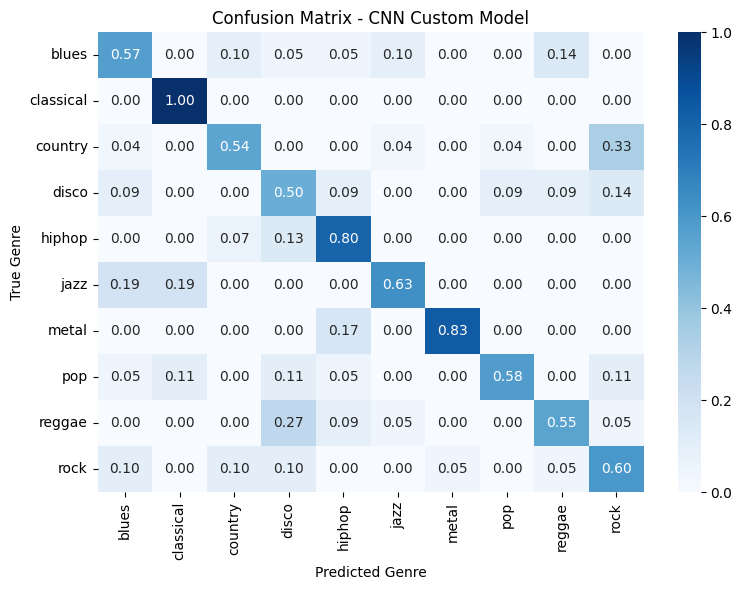

In [35]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=genre_names,
            yticklabels=genre_names)
plt.xlabel('Predicted Genre')
plt.ylabel('True Genre')
plt.title('Confusion Matrix - CNN Custom Model')
plt.tight_layout()
plt.show()

### CRNN Custom Model

In [6]:
from tensorflow.keras import layers, models, regularizers, callbacks

early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(128, 128, 3)),

    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),


    tf.keras.layers.Reshape((32, 2048)),  # 32x(32*64)

    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(y.shape[1], activation='softmax')
])

# Learning rate schedule
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=1000,
    decay_rate=0.9
)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# Fit model
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop]
)

# Evaluate
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f"Test Accuracy: {test_acc:.4f}")


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 32, 2048)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │     1,114,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,135,306 (4.33 MB)

 Trainable params: 1,135,306 (4.33 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 148s 1s/step - accuracy: 0.1844 - loss: 2.1658 - val_accuracy: 0.2628 - val_loss: 1.9033
Epoch 2/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 138s 1s/step - accuracy: 0.3212 - loss: 1.8139 - val_accuracy: 0.4213 - val_loss: 1.6828
Epoch 3/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 150s 1s/step - accuracy: 0.4459 - loss: 1.5239 - val_accuracy: 0.4557 - val_loss: 1.4697
Epoch 4/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 196s 1s/step - accuracy: 0.5153 - loss: 1.3579 - val_accuracy: 0.4953 - val_loss: 1.3664
Epoch 5/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 197s 1s/step - accuracy: 0.5557 - loss: 1.2311 - val_accuracy: 0.5193 - val_loss: 1.3724
Epoch 6/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - accuracy: 0.6052 - loss: 1.1123 - val_accuracy: 0.5819 - val_loss: 1.1784
Epoch 7/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 151s 1s/step - accuracy: 0.6637 - loss: 0.9222 - val_accuracy: 0.5495 - val_loss: 1.3395
Epoch 8/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 148s 1s/step - accuracy: 0.6887 - loss: 0.8647 - val_accu